In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2,baselinish3

from cs231n.data_utils import load_CIFAR10

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

In [3]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


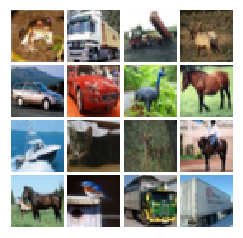

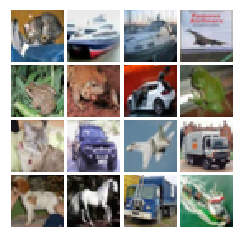

In [4]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
show_images(X_train[:16])
show_images(X_test[:16])

In [5]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha*x,x)

In [6]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    return D_solver, G_solver

In [7]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    label_one = tf.ones_like(logits_fake)
    label_zero = tf.zeros_like(logits_fake)
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake,labels = label_one))
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real,labels = label_one) + \
             tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake,labels = label_zero) )  
    return D_loss, G_loss

In [8]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = 0.5*tf.reduce_mean(tf.square(score_fake-1))
    D_loss = 0.5*tf.reduce_mean(tf.square(score_real-1) + tf.square(score_fake))
    return D_loss, G_loss

In [9]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        #reshaped_x = tf.transpose(x,perm = [0,2,3,1])
        reshaped_x = x
        a1 = tf.layers.conv2d(reshaped_x,filters = 32,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        #new conv layer ## differnece of cifar 10_l2_drop model
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 128,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        #new conv layer
        a1 = tf.layers.conv2d(a1,filters = 128,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 256,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        #new dropout layer
        tf.layers.dropout(a1,training=True,rate = 0.5)
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 512,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        #new dropout layer
        tf.layers.dropout(a1,training=True,rate = 0.5)
        a1 = tf.reshape(a1,shape=[-1,512])
        a1 = tf.layers.dense(a1,512,activation = leaky_relu)
        logits = tf.layers.dense(a1,1)
        #logits2 = tf.layers.dense(a1,10)
        
        
        return logits

In [10]:
def generator(X):
    
    with tf.variable_scope("generator"):
        Float_image = X
        conv_mat = tf.constant(np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],[0.615,-0.514999,-0.10001]]),dtype = tf.float32)
        inv_conv_mat = tf.constant(np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]]),dtype = tf.float32)

        Float_image = tf.reshape(Float_image,[-1,3])

        YUV_image = tf.matmul(Float_image,conv_mat)
        YUV_image = tf.reshape(YUV_image,[-1,32,32,3])
        Float_image = tf.reshape(Float_image,[-1,32,32,3])
        UV_p = YUV_image[:,:,:,1:3]
        Y_p = YUV_image[:,:,:,0:1]
        noise = tf.random_normal(shape = tf.shape(Y_p),mean = 0.0,stddev = 0.01)
        Y_pn = Y_p + noise

        a1 = tf.layers.conv2d(Y_pn,filters = 8,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        a1 = tf.layers.conv2d_transpose(a1,filters = 64, kernel_size = [4,4],strides = [2,2],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        tf.layers.dropout(a1,training=True,rate = 0.5)
        
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        
        tf.layers.dropout(a1,training=True,rate = 0.5)
        
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        tf.layers.dropout(a1,training=True,rate = 0.5)
        
        a1 = tf.layers.conv2d(a1,filters = 8,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 4,kernel_size = [1,1],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 2,kernel_size = [1,1],activation = tf.tanh,padding = 'same')
        a1 = 0.5*a1



        a3 = tf.concat((Y_p,a1),axis = 3)
        #a2 = tf.image.hsv_to_rgb(a3)
        a3 = tf.reshape(a3,[-1,3])
        a2 = tf.matmul(a3,inv_conv_mat)
        RGB_out = tf.reshape(a2,[-1,32,32,3])

    
    return RGB_out,Y_p

In [11]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32,32,3])
y = tf.placeholder(tf.float32,[None,10])
#z = sample_noise(batch_size, noise_dim)
# generated images
G_sample,G_in = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers(learning_rate = 1e-4,beta1 = 0.5)
D_loss, G_loss = gan_loss(logits_real, logits_fake)
#G_loss += tf.reduce_mean(tf.nn.l2_loss(x-G_sample))
#G_loss += tf.reduce_mean(tf.square(x-G_sample))
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [14]:
saver = tf.train.Saver()
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=10, print_every=1, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(50000*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            rand_indices = np.random.choice(np.arange(10000),batch_size)
            minibatch = X_test[rand_indices]
            samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
            fig = show_images2(samples_gray[:16])
            plt.show()
            samples = sess.run(G_sample,feed_dict = {x:minibatch})
            fig = show_images(samples[:16])
            plt.show()
            fig = show_images(minibatch[:16])
            plt.show()
            print ("saving current model")
            saver.save(sess,'../models/gan_model_cifar_drop_l2_new_try')
            
            print()
        # run a batch of data through the network
        #minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        rand_indices = np.random.choice(np.arange(50000),batch_size)
        minibatch = X_train[rand_indices]
        #print(minibatch.dtype)
        #print (minibatch.shape)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        while(D_loss_curr > 0.2):
            rand_indices = np.random.choice(np.arange(50000),batch_size)
            minibatch = X_train[rand_indices]
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x:minibatch})
        
        while(G_loss_curr > 0.2):
            rand_indices = np.random.choice(np.arange(50000),batch_size)
            minibatch = X_train[rand_indices]
            _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x:minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    #print('Final images')
    #samples = sess.run(G_sample)

    #fig = show_images(samples[:16])
    #plt.show()

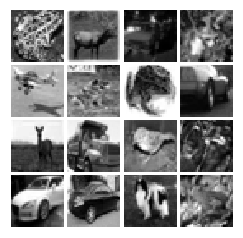

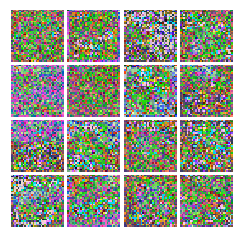

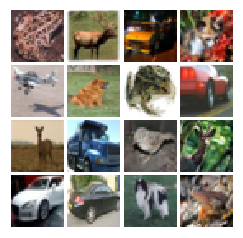

saving current model

Iter: 0, D: 0.1192, G:0.1935
Iter: 1, D: 0.172, G:0.1979
Iter: 2, D: 0.1745, G:0.1903
Iter: 3, D: 0.1336, G:0.1877
Iter: 4, D: 0.1662, G:0.1888
Iter: 5, D: 0.1918, G:0.1945
Iter: 6, D: 0.1929, G:0.1914
Iter: 7, D: 0.1365, G:0.192
Iter: 8, D: 0.1724, G:0.1999
Iter: 9, D: 0.1947, G:0.1626


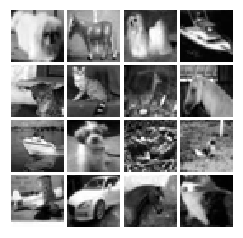

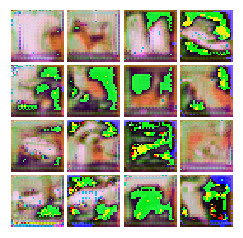

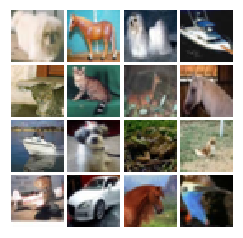

saving current model

Iter: 10, D: 0.1726, G:0.1973
Iter: 11, D: 0.1485, G:0.1881
Iter: 12, D: 0.1885, G:0.1996
Iter: 13, D: 0.1567, G:0.1941
Iter: 14, D: 0.183, G:0.1949
Iter: 15, D: 0.1179, G:0.1606
Iter: 16, D: 0.1955, G:0.1749
Iter: 17, D: 0.1646, G:0.141
Iter: 18, D: 0.1856, G:0.1915
Iter: 19, D: 0.1693, G:0.1541


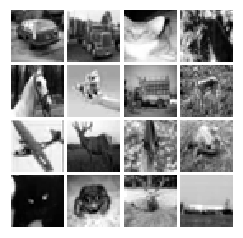

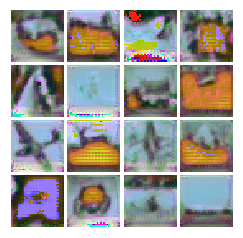

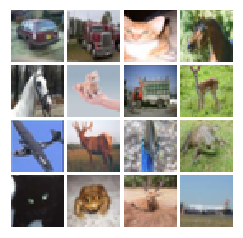

saving current model

Iter: 20, D: 0.185, G:0.107
Iter: 21, D: 0.1706, G:0.1854
Iter: 22, D: 0.1816, G:0.1978
Iter: 23, D: 0.1697, G:0.1751
Iter: 24, D: 0.1808, G:0.1913
Iter: 25, D: 0.1992, G:0.1848
Iter: 26, D: 0.1828, G:0.1819
Iter: 27, D: 0.1918, G:0.1855
Iter: 28, D: 0.1999, G:0.1641
Iter: 29, D: 0.1904, G:0.1863


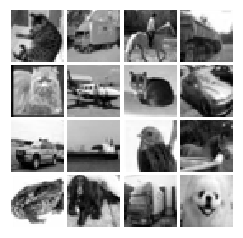

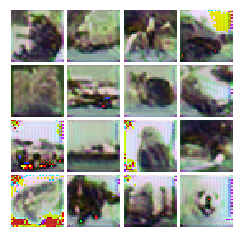

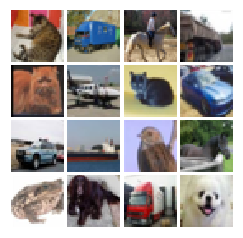

saving current model

Iter: 30, D: 0.1953, G:0.1577
Iter: 31, D: 0.1438, G:0.1364
Iter: 32, D: 0.1738, G:0.1683
Iter: 33, D: 0.1826, G:0.1342
Iter: 34, D: 0.1824, G:0.1914
Iter: 35, D: 0.1951, G:0.1938
Iter: 36, D: 0.1384, G:0.191
Iter: 37, D: 0.1977, G:0.1878
Iter: 38, D: 0.1897, G:0.1991
Iter: 39, D: 0.1709, G:0.1872


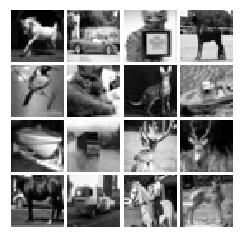

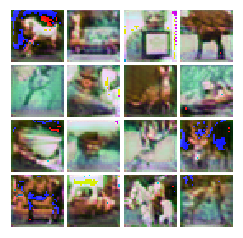

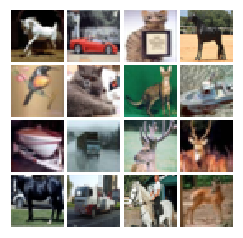

saving current model

Iter: 40, D: 0.1735, G:0.1703
Iter: 41, D: 0.1877, G:0.184
Iter: 42, D: 0.2, G:0.1849
Iter: 43, D: 0.1868, G:0.1874
Iter: 44, D: 0.1895, G:0.185
Iter: 45, D: 0.1787, G:0.1855
Iter: 46, D: 0.1837, G:0.1318
Iter: 47, D: 0.184, G:0.1889
Iter: 48, D: 0.1681, G:0.1902
Iter: 49, D: 0.1971, G:0.1782


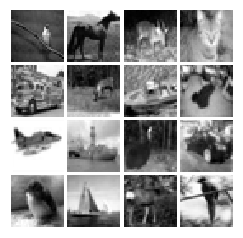

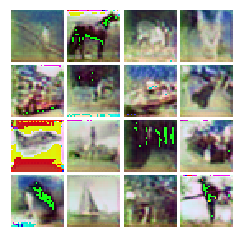

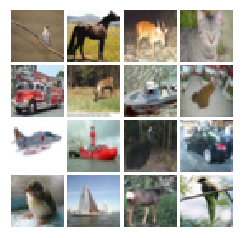

saving current model

Iter: 50, D: 0.1988, G:0.1892
Iter: 51, D: 0.1701, G:0.1936
Iter: 52, D: 0.175, G:0.1864
Iter: 53, D: 0.1823, G:0.1923
Iter: 54, D: 0.1923, G:0.1591
Iter: 55, D: 0.1869, G:0.186
Iter: 56, D: 0.1313, G:0.1955
Iter: 57, D: 0.1818, G:0.1899
Iter: 58, D: 0.1248, G:0.1891
Iter: 59, D: 0.1997, G:0.1807


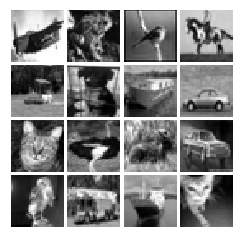

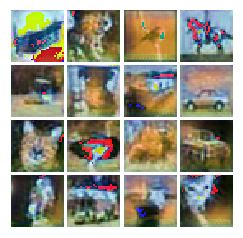

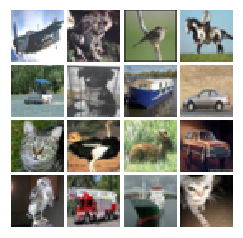

saving current model

Iter: 60, D: 0.1639, G:0.1999
Iter: 61, D: 0.1842, G:0.176
Iter: 62, D: 0.1568, G:0.1951
Iter: 63, D: 0.1718, G:0.1759
Iter: 64, D: 0.1748, G:0.1889
Iter: 65, D: 0.192, G:0.1961
Iter: 66, D: 0.1969, G:0.1969
Iter: 67, D: 0.1472, G:0.1813
Iter: 68, D: 0.182, G:0.1933
Iter: 69, D: 0.1918, G:0.1914


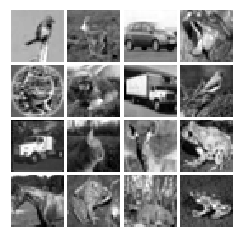

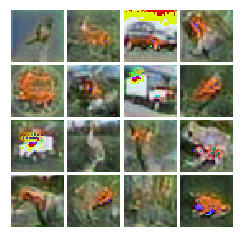

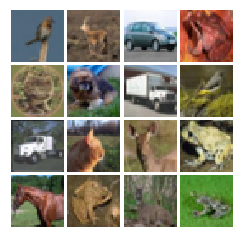

saving current model

Iter: 70, D: 0.1863, G:0.1978
Iter: 71, D: 0.1985, G:0.1753
Iter: 72, D: 0.1484, G:0.1864
Iter: 73, D: 0.1599, G:0.1926
Iter: 74, D: 0.1902, G:0.1803
Iter: 75, D: 0.153, G:0.1956
Iter: 76, D: 0.1637, G:0.1984
Iter: 77, D: 0.135, G:0.1655
Iter: 78, D: 0.1673, G:0.1947
Iter: 79, D: 0.199, G:0.1697


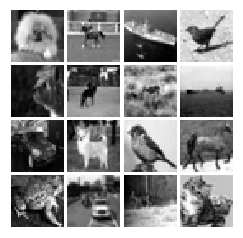

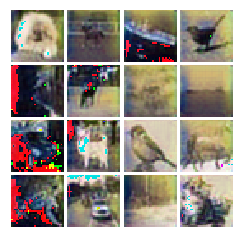

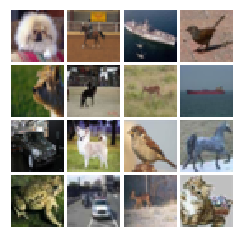

saving current model

Iter: 80, D: 0.1961, G:0.19
Iter: 81, D: 0.155, G:0.1916
Iter: 82, D: 0.1815, G:0.1879
Iter: 83, D: 0.1753, G:0.1768
Iter: 84, D: 0.1981, G:0.1959
Iter: 85, D: 0.1966, G:0.1847
Iter: 86, D: 0.1452, G:0.1988
Iter: 87, D: 0.1931, G:0.1748
Iter: 88, D: 0.1686, G:0.161
Iter: 89, D: 0.1716, G:0.1887


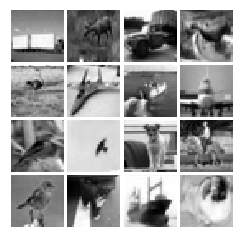

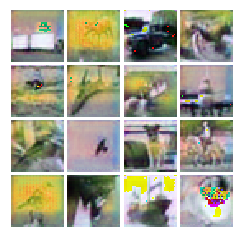

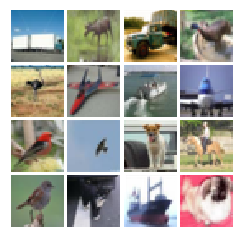

saving current model

Iter: 90, D: 0.132, G:0.1871
Iter: 91, D: 0.1886, G:0.1956
Iter: 92, D: 0.1883, G:0.1928
Iter: 93, D: 0.1735, G:0.1804
Iter: 94, D: 0.1591, G:0.1845
Iter: 95, D: 0.1886, G:0.1695
Iter: 96, D: 0.1741, G:0.1951
Iter: 97, D: 0.1932, G:0.1991
Iter: 98, D: 0.1824, G:0.1899
Iter: 99, D: 0.1962, G:0.197


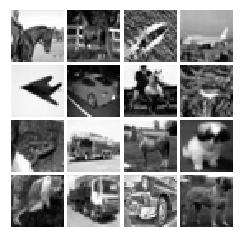

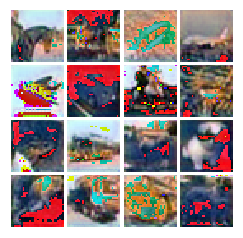

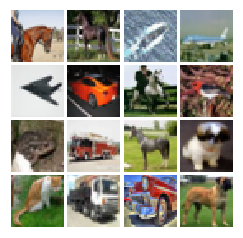

saving current model

Iter: 100, D: 0.1897, G:0.1954
Iter: 101, D: 0.166, G:0.1838
Iter: 102, D: 0.1506, G:0.1977
Iter: 103, D: 0.1981, G:0.1971
Iter: 104, D: 0.1888, G:0.1968
Iter: 105, D: 0.1866, G:0.189
Iter: 106, D: 0.1933, G:0.1965
Iter: 107, D: 0.1966, G:0.1947
Iter: 108, D: 0.1646, G:0.1734
Iter: 109, D: 0.1971, G:0.182


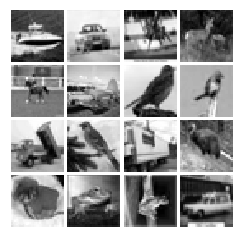

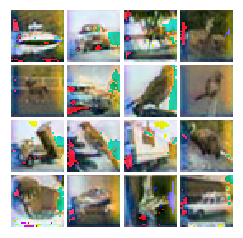

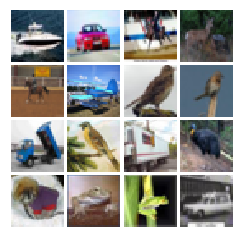

saving current model

Iter: 110, D: 0.1688, G:0.1912
Iter: 111, D: 0.1926, G:0.1994
Iter: 112, D: 0.1685, G:0.1807
Iter: 113, D: 0.167, G:0.1956
Iter: 114, D: 0.1929, G:0.1885
Iter: 115, D: 0.1776, G:0.1871
Iter: 116, D: 0.1959, G:0.1909
Iter: 117, D: 0.1863, G:0.1761
Iter: 118, D: 0.1989, G:0.1935
Iter: 119, D: 0.1766, G:0.195


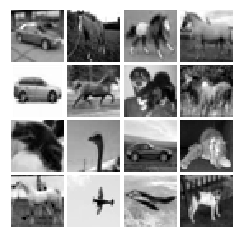

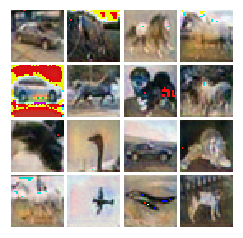

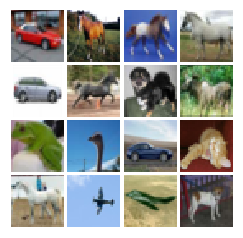

saving current model

Iter: 120, D: 0.1971, G:0.1987
Iter: 121, D: 0.1244, G:0.1801
Iter: 122, D: 0.1948, G:0.1917
Iter: 123, D: 0.1871, G:0.1911
Iter: 124, D: 0.1612, G:0.1937
Iter: 125, D: 0.1919, G:0.2
Iter: 126, D: 0.1871, G:0.1893
Iter: 127, D: 0.1899, G:0.1865
Iter: 128, D: 0.1808, G:0.1943
Iter: 129, D: 0.1148, G:0.1943


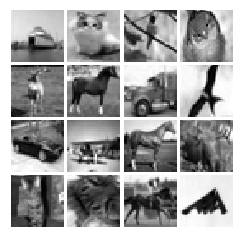

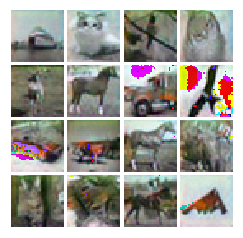

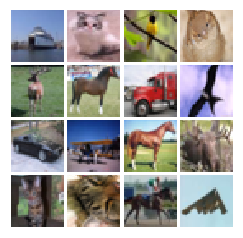

saving current model

Iter: 130, D: 0.1609, G:0.1964
Iter: 131, D: 0.163, G:0.1868
Iter: 132, D: 0.1788, G:0.1932
Iter: 133, D: 0.1653, G:0.1985
Iter: 134, D: 0.134, G:0.1991
Iter: 135, D: 0.1576, G:0.1993
Iter: 136, D: 0.1536, G:0.1996
Iter: 137, D: 0.197, G:0.1988
Iter: 138, D: 0.1773, G:0.1983
Iter: 139, D: 0.193, G:0.1989


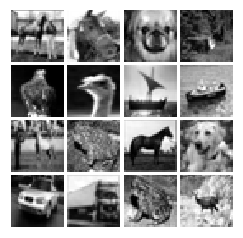

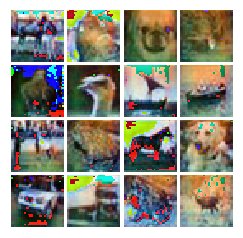

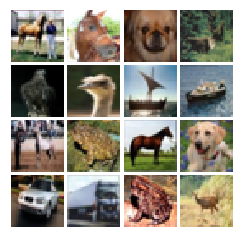

saving current model

Iter: 140, D: 0.1899, G:0.1989
Iter: 141, D: 0.169, G:0.1998
Iter: 142, D: 0.1612, G:0.1881
Iter: 143, D: 0.19, G:0.1979
Iter: 144, D: 0.1884, G:0.1973
Iter: 145, D: 0.1472, G:0.1691
Iter: 146, D: 0.1925, G:0.1976
Iter: 147, D: 0.1892, G:0.1869
Iter: 148, D: 0.1956, G:0.1913
Iter: 149, D: 0.1988, G:0.182


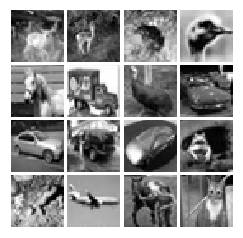

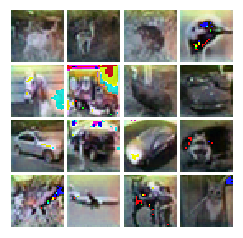

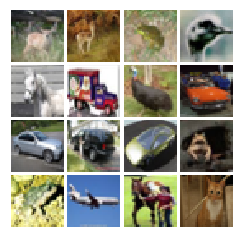

saving current model

Iter: 150, D: 0.1951, G:0.1792
Iter: 151, D: 0.1814, G:0.1926
Iter: 152, D: 0.1664, G:0.1938
Iter: 153, D: 0.1769, G:0.1952
Iter: 154, D: 0.1914, G:0.1985
Iter: 155, D: 0.1739, G:0.1991
Iter: 156, D: 0.1255, G:0.1931
Iter: 157, D: 0.1791, G:0.1942
Iter: 158, D: 0.1481, G:0.1993
Iter: 159, D: 0.1883, G:0.192


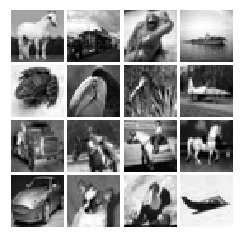

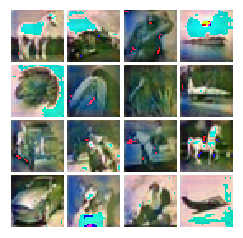

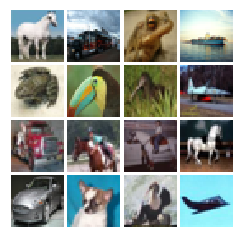

saving current model

Iter: 160, D: 0.1799, G:0.1972
Iter: 161, D: 0.1732, G:0.1982
Iter: 162, D: 0.1966, G:0.1973
Iter: 163, D: 0.1908, G:0.1965
Iter: 164, D: 0.1873, G:0.1989
Iter: 165, D: 0.1912, G:0.197
Iter: 166, D: 0.1638, G:0.1994
Iter: 167, D: 0.1884, G:0.1903
Iter: 168, D: 0.1909, G:0.1877
Iter: 169, D: 0.1853, G:0.1887


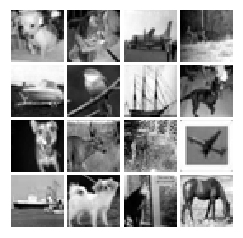

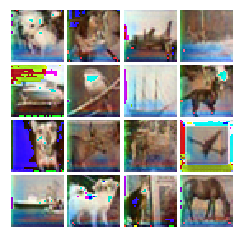

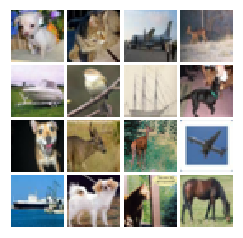

saving current model

Iter: 170, D: 0.176, G:0.1972
Iter: 171, D: 0.1726, G:0.1977
Iter: 172, D: 0.199, G:0.1919
Iter: 173, D: 0.1823, G:0.1957
Iter: 174, D: 0.1673, G:0.1983
Iter: 175, D: 0.1771, G:0.1966
Iter: 176, D: 0.1758, G:0.1929
Iter: 177, D: 0.1846, G:0.1995
Iter: 178, D: 0.1725, G:0.199
Iter: 179, D: 0.1948, G:0.188


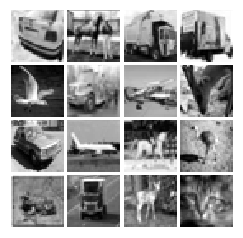

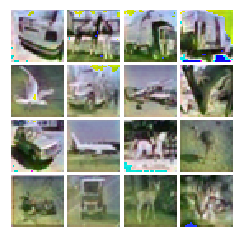

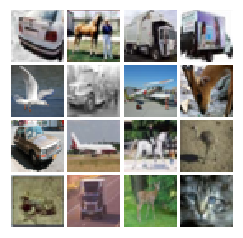

saving current model

Iter: 180, D: 0.1829, G:0.1993
Iter: 181, D: 0.1801, G:0.199
Iter: 182, D: 0.1544, G:0.1832
Iter: 183, D: 0.1694, G:0.197
Iter: 184, D: 0.1553, G:0.1947
Iter: 185, D: 0.1795, G:0.1914
Iter: 186, D: 0.1694, G:0.1955
Iter: 187, D: 0.1933, G:0.1786
Iter: 188, D: 0.1792, G:0.1961
Iter: 189, D: 0.1989, G:0.1862


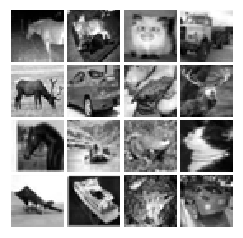

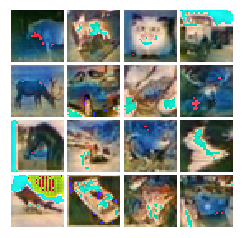

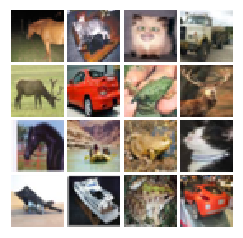

saving current model

Iter: 190, D: 0.1882, G:0.1988
Iter: 191, D: 0.1941, G:0.1999
Iter: 192, D: 0.1546, G:0.1949
Iter: 193, D: 0.194, G:0.2
Iter: 194, D: 0.1903, G:0.1969
Iter: 195, D: 0.1844, G:0.1999
Iter: 196, D: 0.1703, G:0.1981
Iter: 197, D: 0.1876, G:0.1985
Iter: 198, D: 0.149, G:0.1978
Iter: 199, D: 0.1949, G:0.1997


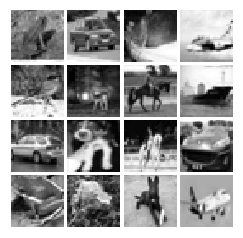

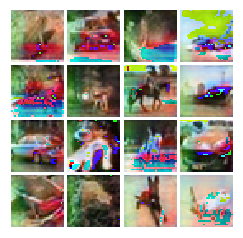

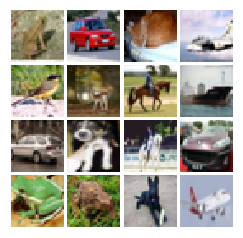

saving current model

Iter: 200, D: 0.1891, G:0.1944
Iter: 201, D: 0.1739, G:0.1948
Iter: 202, D: 0.1935, G:0.1976
Iter: 203, D: 0.1845, G:0.1981
Iter: 204, D: 0.1845, G:0.1985
Iter: 205, D: 0.1989, G:0.1946
Iter: 206, D: 0.154, G:0.1878
Iter: 207, D: 0.1825, G:0.1989
Iter: 208, D: 0.1977, G:0.1921
Iter: 209, D: 0.1686, G:0.1987


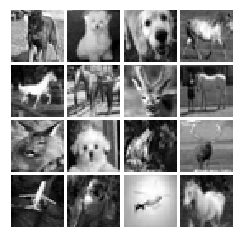

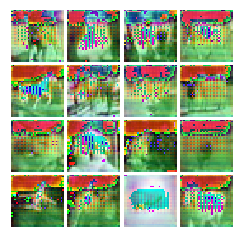

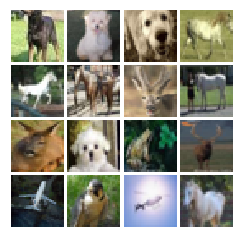

saving current model

Iter: 210, D: 0.1896, G:0.1821
Iter: 211, D: 0.1886, G:0.1999
Iter: 212, D: 0.184, G:0.1934
Iter: 213, D: 0.1939, G:0.1973
Iter: 214, D: 0.1953, G:0.1974
Iter: 215, D: 0.1852, G:0.1988
Iter: 216, D: 0.1992, G:0.1935
Iter: 217, D: 0.1602, G:0.1984
Iter: 218, D: 0.1999, G:0.1908
Iter: 219, D: 0.1943, G:0.1964


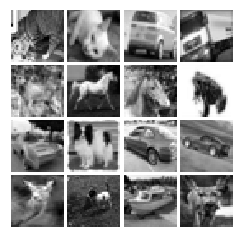

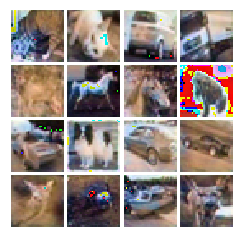

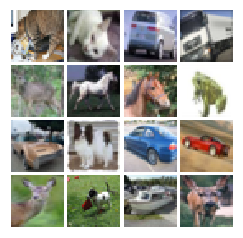

saving current model

Iter: 220, D: 0.1828, G:0.1921
Iter: 221, D: 0.1934, G:0.189
Iter: 222, D: 0.1491, G:0.1969
Iter: 223, D: 0.1787, G:0.1962
Iter: 224, D: 0.1834, G:0.1982
Iter: 225, D: 0.1691, G:0.1945
Iter: 226, D: 0.1796, G:0.1986
Iter: 227, D: 0.1751, G:0.1911
Iter: 228, D: 0.1857, G:0.1964
Iter: 229, D: 0.1942, G:0.199


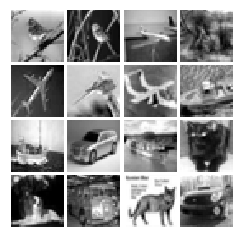

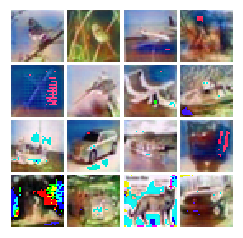

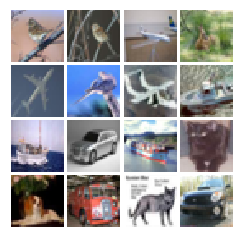

saving current model

Iter: 230, D: 0.1775, G:0.1994
Iter: 231, D: 0.1952, G:0.1975
Iter: 232, D: 0.1972, G:0.1988
Iter: 233, D: 0.1659, G:0.1817
Iter: 234, D: 0.1861, G:0.1994
Iter: 235, D: 0.1769, G:0.1952
Iter: 236, D: 0.1982, G:0.1974
Iter: 237, D: 0.1767, G:0.1975
Iter: 238, D: 0.1992, G:0.1983
Iter: 239, D: 0.1816, G:0.1825


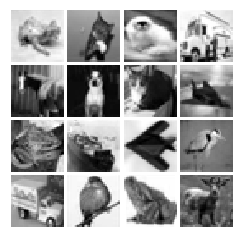

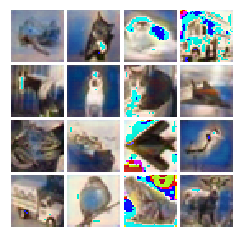

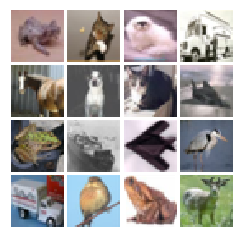

saving current model

Iter: 240, D: 0.1575, G:0.1947
Iter: 241, D: 0.1681, G:0.1921
Iter: 242, D: 0.189, G:0.1994
Iter: 243, D: 0.156, G:0.1966
Iter: 244, D: 0.1784, G:0.1988
Iter: 245, D: 0.1969, G:0.1975
Iter: 246, D: 0.1925, G:0.1993
Iter: 247, D: 0.1812, G:0.1937
Iter: 248, D: 0.1654, G:0.1944
Iter: 249, D: 0.1943, G:0.1871


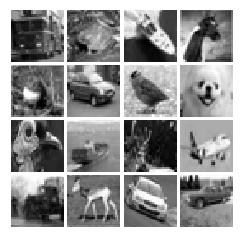

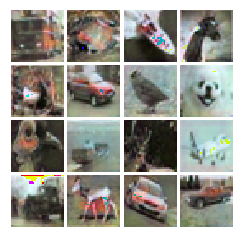

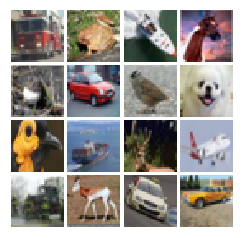

saving current model

Iter: 250, D: 0.173, G:0.1925
Iter: 251, D: 0.1869, G:0.1982
Iter: 252, D: 0.1824, G:0.199
Iter: 253, D: 0.1727, G:0.1897
Iter: 254, D: 0.1979, G:0.1934
Iter: 255, D: 0.197, G:0.1995
Iter: 256, D: 0.1477, G:0.1986
Iter: 257, D: 0.1894, G:0.1973
Iter: 258, D: 0.183, G:0.1919
Iter: 259, D: 0.188, G:0.1932


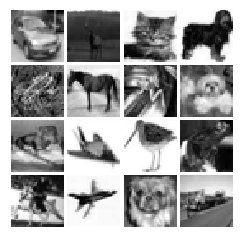

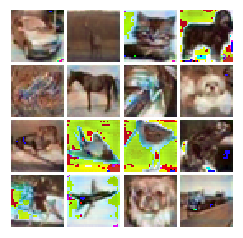

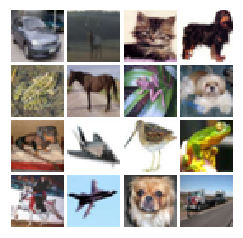

saving current model

Iter: 260, D: 0.1969, G:0.1977
Iter: 261, D: 0.1732, G:0.1968
Iter: 262, D: 0.163, G:0.1964
Iter: 263, D: 0.168, G:0.1985
Iter: 264, D: 0.1901, G:0.1993
Iter: 265, D: 0.1544, G:0.1962
Iter: 266, D: 0.1826, G:0.1985
Iter: 267, D: 0.1595, G:0.1841
Iter: 268, D: 0.1951, G:0.1985
Iter: 269, D: 0.1646, G:0.1999


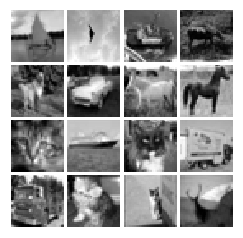

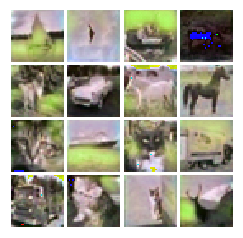

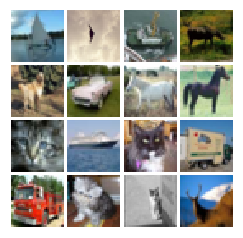

saving current model

Iter: 270, D: 0.1981, G:0.1982
Iter: 271, D: 0.1595, G:0.1994
Iter: 272, D: 0.1856, G:0.199
Iter: 273, D: 0.1765, G:0.1997
Iter: 274, D: 0.1943, G:0.189
Iter: 275, D: 0.1972, G:0.1976
Iter: 276, D: 0.1895, G:0.1929
Iter: 277, D: 0.193, G:0.1866
Iter: 278, D: 0.1739, G:0.199
Iter: 279, D: 0.1907, G:0.1986


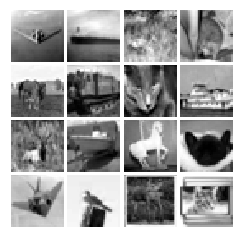

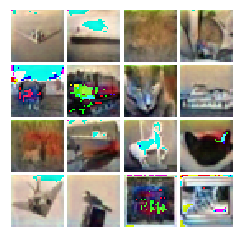

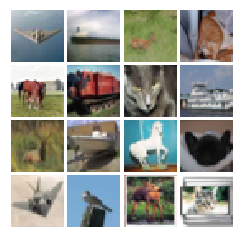

saving current model

Iter: 280, D: 0.1728, G:0.1991
Iter: 281, D: 0.1821, G:0.1978
Iter: 282, D: 0.1822, G:0.1959
Iter: 283, D: 0.1677, G:0.1898
Iter: 284, D: 0.195, G:0.1909
Iter: 285, D: 0.1903, G:0.1991
Iter: 286, D: 0.1519, G:0.1903
Iter: 287, D: 0.1986, G:0.1965
Iter: 288, D: 0.2, G:0.1997
Iter: 289, D: 0.1605, G:0.1969


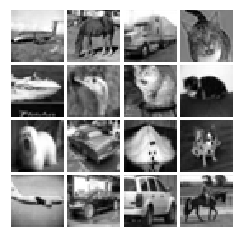

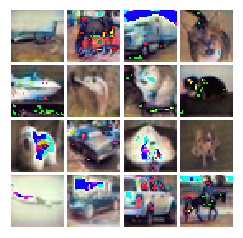

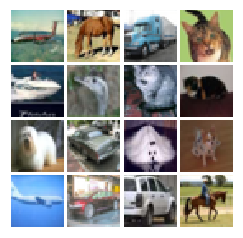

saving current model

Iter: 290, D: 0.167, G:0.1972
Iter: 291, D: 0.164, G:0.1946
Iter: 292, D: 0.193, G:0.1911
Iter: 293, D: 0.1826, G:0.1967
Iter: 294, D: 0.1769, G:0.1995
Iter: 295, D: 0.1708, G:0.187
Iter: 296, D: 0.1864, G:0.1841
Iter: 297, D: 0.1902, G:0.1946
Iter: 298, D: 0.1604, G:0.1925
Iter: 299, D: 0.1878, G:0.1958


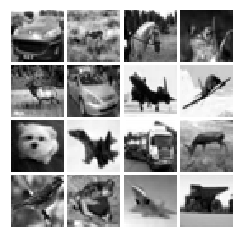

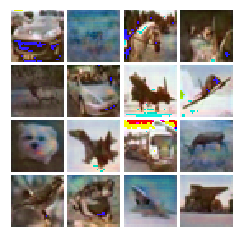

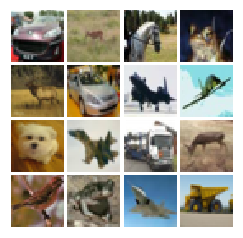

saving current model

Iter: 300, D: 0.1739, G:0.1994
Iter: 301, D: 0.1887, G:0.1994
Iter: 302, D: 0.1732, G:0.1787
Iter: 303, D: 0.1697, G:0.1932
Iter: 304, D: 0.1697, G:0.1996
Iter: 305, D: 0.177, G:0.1964
Iter: 306, D: 0.1884, G:0.1965
Iter: 307, D: 0.1927, G:0.1968
Iter: 308, D: 0.1694, G:0.1959
Iter: 309, D: 0.1902, G:0.1944


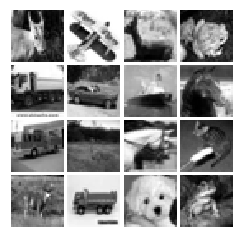

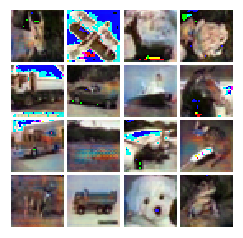

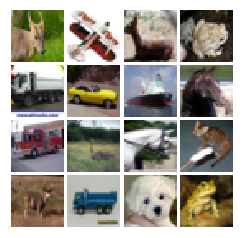

saving current model

Iter: 310, D: 0.1755, G:0.1965
Iter: 311, D: 0.1999, G:0.1897
Iter: 312, D: 0.182, G:0.1902
Iter: 313, D: 0.193, G:0.1996
Iter: 314, D: 0.1768, G:0.1975
Iter: 315, D: 0.1727, G:0.1905
Iter: 316, D: 0.1688, G:0.1986
Iter: 317, D: 0.1476, G:0.1969
Iter: 318, D: 0.1653, G:0.1899
Iter: 319, D: 0.1935, G:0.1966


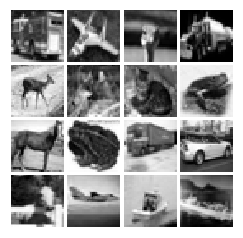

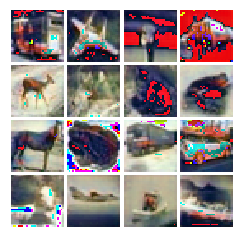

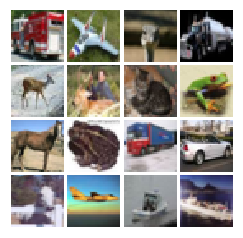

saving current model

Iter: 320, D: 0.1575, G:0.1906
Iter: 321, D: 0.1475, G:0.1947
Iter: 322, D: 0.1992, G:0.1913
Iter: 323, D: 0.1824, G:0.1979
Iter: 324, D: 0.1701, G:0.1979
Iter: 325, D: 0.1965, G:0.1956
Iter: 326, D: 0.1864, G:0.1986
Iter: 327, D: 0.1744, G:0.1893
Iter: 328, D: 0.1916, G:0.1903
Iter: 329, D: 0.173, G:0.1978


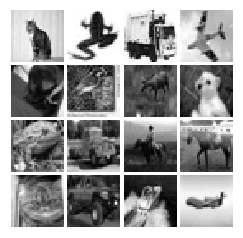

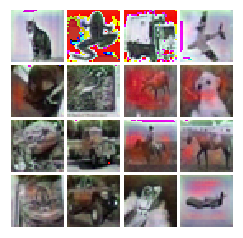

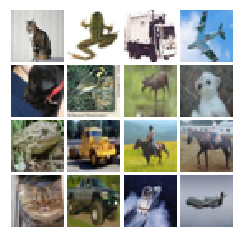

saving current model

Iter: 330, D: 0.1583, G:0.1909
Iter: 331, D: 0.198, G:0.1942
Iter: 332, D: 0.1991, G:0.1922
Iter: 333, D: 0.1997, G:0.1948
Iter: 334, D: 0.1877, G:0.1933
Iter: 335, D: 0.1705, G:0.1933
Iter: 336, D: 0.1943, G:0.1985
Iter: 337, D: 0.1972, G:0.1929
Iter: 338, D: 0.1966, G:0.1998
Iter: 339, D: 0.1521, G:0.1914


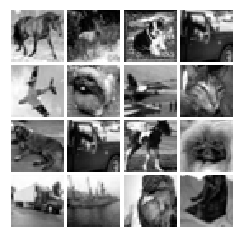

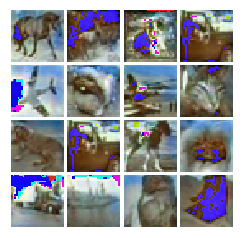

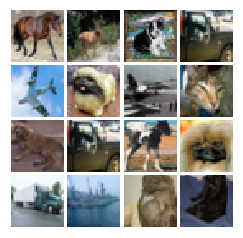

saving current model

Iter: 340, D: 0.1903, G:0.1996
Iter: 341, D: 0.199, G:0.198
Iter: 342, D: 0.1912, G:0.1953
Iter: 343, D: 0.1737, G:0.1998
Iter: 344, D: 0.1982, G:0.1949
Iter: 345, D: 0.1923, G:0.1903
Iter: 346, D: 0.1911, G:0.1966
Iter: 347, D: 0.1977, G:0.1988
Iter: 348, D: 0.189, G:0.1927
Iter: 349, D: 0.1785, G:0.1983


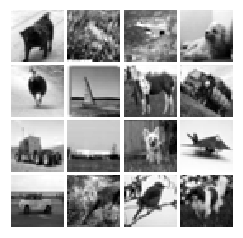

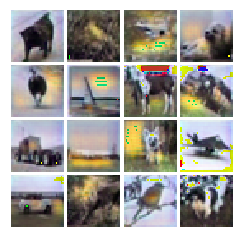

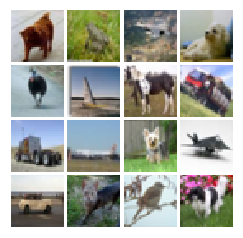

saving current model

Iter: 350, D: 0.1768, G:0.1991
Iter: 351, D: 0.1817, G:0.1964
Iter: 352, D: 0.1802, G:0.196
Iter: 353, D: 0.1692, G:0.1977
Iter: 354, D: 0.1979, G:0.1981
Iter: 355, D: 0.1945, G:0.1912
Iter: 356, D: 0.1933, G:0.1997
Iter: 357, D: 0.1916, G:0.1967
Iter: 358, D: 0.1919, G:0.1988
Iter: 359, D: 0.1743, G:0.1831


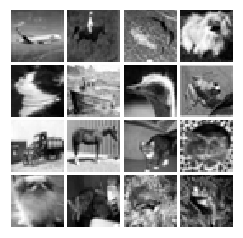

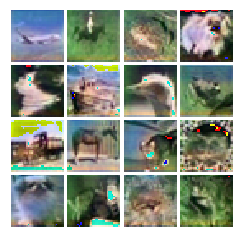

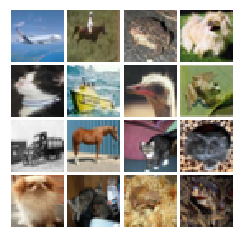

saving current model

Iter: 360, D: 0.1982, G:0.1999
Iter: 361, D: 0.1514, G:0.1963
Iter: 362, D: 0.1806, G:0.1993
Iter: 363, D: 0.1986, G:0.1973
Iter: 364, D: 0.1883, G:0.1975
Iter: 365, D: 0.1789, G:0.1974
Iter: 366, D: 0.1714, G:0.1914
Iter: 367, D: 0.1812, G:0.1919
Iter: 368, D: 0.1867, G:0.1967
Iter: 369, D: 0.1591, G:0.1988


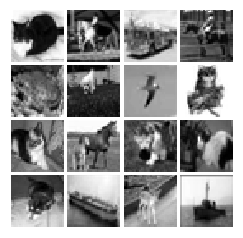

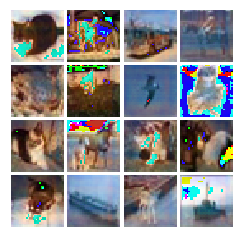

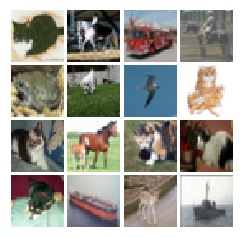

saving current model

Iter: 370, D: 0.1825, G:0.195
Iter: 371, D: 0.1964, G:0.1986
Iter: 372, D: 0.1861, G:0.1994
Iter: 373, D: 0.1944, G:0.1993
Iter: 374, D: 0.1985, G:0.1989
Iter: 375, D: 0.175, G:0.1991
Iter: 376, D: 0.1988, G:0.1961


KeyboardInterrupt: 

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,num_epoch = 2)

INFO:tensorflow:Restoring parameters from ../models/gan_model_cifar_drop_l2_new_try


INFO:tensorflow:Restoring parameters from ../models/gan_model_cifar_drop_l2_new_try


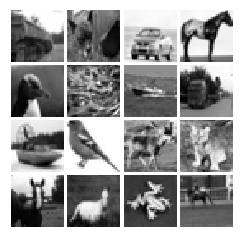

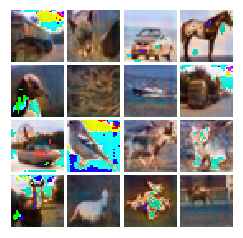

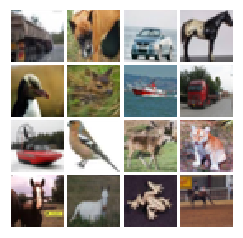

In [17]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/gan_model_cifar_drop_l2_new_try')
rand_indices = np.random.choice(np.arange(10000),batch_size)
minibatch = X_test[rand_indices]
samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
fig = show_images2(samples_gray[:16])
plt.show()
samples = sess.run(G_sample,feed_dict = {x:minibatch})
fig = show_images(samples[:16])
plt.show()
fig = show_images(minibatch[:16])
plt.show()


In [12]:
def generator(X):
    
    with tf.variable_scope("generator"):
        Float_image = X
        
        conv_mat = tf.constant(np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],[0.615,-0.514999,-0.10001]]),dtype = tf.float32)
        inv_conv_mat = tf.constant(np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]]),dtype = tf.float32)

        Float_image = tf.reshape(Float_image,[-1,3])

        YUV_image = tf.matmul(Float_image,conv_mat)
        YUV_image = tf.reshape(YUV_image,[-1,32,32,3])
        Float_image = tf.reshape(Float_image,[-1,32,32,3])
        UV_p = YUV_image[:,:,:,1:3]
        Y_p = YUV_image[:,:,:,0:1]
        noise = tf.random_uniform(shape = tf.shape(Y_p),minval = -0.2, maxval = 0.2)
        Y_p = Y_p + noise

        a1 = tf.layers.conv2d(Y_p,filters = 16,kernel_size = [5,5],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 8,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 2,kernel_size = [1,1],activation = tf.tanh,padding = 'same')



        a3 = tf.concat((Y_p,a1),axis = 3)
        #a2 = tf.image.hsv_to_rgb(a3)
        a3 = tf.reshape(a3,[-1,3])
        a2 = tf.matmul(a3,inv_conv_mat)
        RGB_out = tf.reshape(a2,[-1,32,32,3])

    
    return RGB_out,Y_p

In [13]:
tf.reset_default_graph()

batch_size = 64
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32,32,3])
#z = sample_noise(batch_size, noise_dim)
# generated images
G_sample,G_in = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [18]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(50000*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            rand_indices = np.random.choice(np.arange(49000),batch_size)
            minibatch = X_train[rand_indices]
            samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
            fig = show_images2(samples_gray[:16])
            plt.show()
            samples = sess.run(G_sample,feed_dict = {x:minibatch})
            fig = show_images(samples[:16])
            plt.show()
            fig = show_images(minibatch[:16])
            plt.show()
            
            print()
        # run a batch of data through the network
        #minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        for ll in range(1):
            rand_indices = np.random.choice(np.arange(49000),batch_size)
            minibatch = X_train[rand_indices]
        #print(minibatch.dtype)
        #print (minibatch.shape)
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x:minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    #print('Final images')
    #samples = sess.run(G_sample)

    #fig = show_images(samples[:16])
    #plt.show()

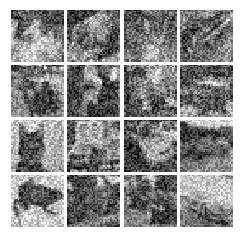

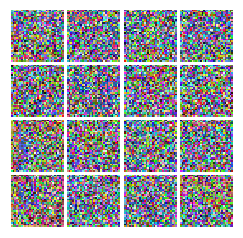

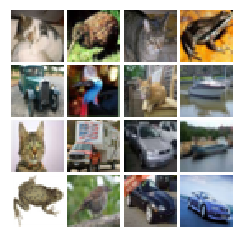


Iter: 0, D: 0.4855, G:0.4221

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,num_epoch = 20)

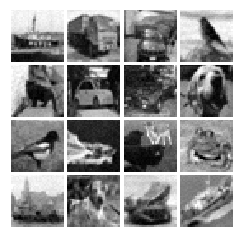

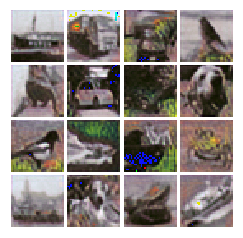

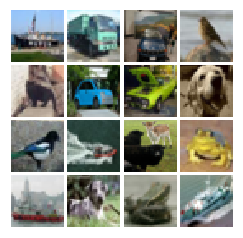

In [46]:
rand_indices = np.random.choice(np.arange(49000),batch_size)
minibatch = X_train[rand_indices]
samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
fig = show_images2(samples_gray[:16])
plt.show()
samples = sess.run(G_sample,feed_dict = {x:minibatch})
fig = show_images(samples[:16])
plt.show()
fig = show_images(minibatch[:16])
plt.show()
            

In [ ]:
saver = tf.train.Saver()
saver.save(sess,'gan_model2')